In [2]:
# imports
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import numpy as np
import cv2
import time


# Skeletonization of Binary Images


## Premises

In this notebook I implement, demonstrate and compare various algorithms to perform Skeletonization of 2D images. For each algoritm presented there is a brief explanation of its logic and mechanism. The algorithms presented are:

1.  Zhang's algorithms (1984)
2.  Morphological Thinning
3.  Lee's algorithms (1994)

My implementations are not meant to be the most efficient but rather simple to understand, leaving out specific code optimizations.

The language used is Python in conjunction with `numpy`, `scikit-image` and `opencv` libraries to perform image processing. `scikit-image` has already implemented (and optimized) versions of skeletonization algorithms.


## What is skeletonization

Skeletonization is an image processing technique which reduces binary objects (e.g. images) to 1 pixel wide representations. This can be useful for feature extraction, and/or representing an object’s topology (2D or 3D).

The skeleton of a region should fulfill the following conditions:

1. Be a connected subset of points from the original region.
2. Represent the geometric characterstics of the original region.
3. Preserve some topological characterstics of the original region, such as connectivity and holes.

There are three major skeletonization techniques:

- Medial axis distance transform.
- Non-pixel-based methods (determine
  analytically the symmetric points of a shape from
  opposite points in the shape edge and use them to extract the skeleton).
- Thinning techniques.

In this notebook I will discuss different _thinning_ algorithms since they are quite efficient and commonly
used in state-of-the-art applications.

The code below demonstrates an example of skeletonized binary image using `scikit-image` library.


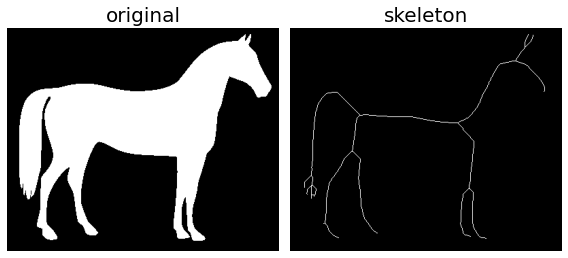

In [3]:
# Invert the horse image
image = invert(data.horse())

# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()


# Zhang's Algorithm

[Zha84] A fast parallel algorithm for thinning digital patterns,
T. Y. Zhang and C. Y. Suen, Communications of the ACM,
March 1984, Volume 27, Number 3.

A binary image is defined by a matrix `M` where each pixel `M[i][j]` is either 0 or 1. A region in the image is more than 1 pixel thick.
Zhang's algorithm iterates over the image until stability applying a transformation on each pixel based on the values of neighbouring pixels.

Given an element of the matrix `M[i][j]` that we call $P_1$, the neighbours of $P_1$ are defined as follows.

|                    |                  |                    |
| ------------------ | ---------------- | ------------------ |
| $P_9$ `[i-1][j-1]` | $P_2$ `[i-1][j]` | $P_3$ `[i-1][j+1]` |
| $P_8$ `[i][j-1]`   | $P_1$ `[i][j]`   | $P_4$ `[i][j+1]`   |
| $P_7$ `[i+1][j-1]` | $P_6$ `[i+1][j]` | $P_5$ `[i+1][j+1]` |

Since it is a parallel algorithm the new value given to a pixel at the $n$-th iteration depends on ts own value as well as those of its eight neighbors at the $(n-1)$-th iteration. This allows all pixel to be processed simultanously.

For the sake of simplicity, my implementation processes pixels in series and do not utilize parallel programming tecniques. In the repository you can find a C++ parallel implementation with `std::threads`

The algorithm consist of iteratively removing all contour points which satify some conditions. An iteration is divided into two sub-iterations with different conditions to be satisfied.

For sub-iteration 1 a point $P_1$ is deleted if the following conditions are satisfied:

1. $2 ≤ B(P_1) ≤ 6$
2. $A(P_1) = 1$
3. $P_2 * P_4 * P_6 = 0$
4. $P_4 * P_6 * P_8 = 0$

where $B(P_1)$ is the number of non zero neighbours of $P_1$ and $A(P_1)$ is the number of 0-1 patterns in the set of neighbours orderd as $P_2, P_3, \dots, P_8, P_9$.
Condition 1. and 2. are needed, respectively, in order to preserve the endpoints of a skeleton and to preserve connectivity, i.e. to prevent the deletion of points which lie between endpoints, as showed by the figure below.
Conditions 3. and 4. together allow to remove from the region an East or South boundary point or a North-West corner point.

![connectivity-endpoints.png](https://drive.google.com/uc?id=1a9l0QBQLm6NglUp4BGT04GurRVw6JFY8)

For sub-iteration 2 only condition 3. and 4. are changed as follows:

3. $P_2 * P_4 * P_8 = 0$
4. $P_2 * P_6 * P_8 = 0$

The new conditions 3. and 4. together allow to remove from the region an West or North boundary point or a South-East corner point.


In [14]:
def zhang_skeletonize(image, save_steps=False, path_to_save_steps="stepbystep_exec/zhang/"):
    '''Given a 2D binary image, skeletonize it using Zhang's Method'''

    # add padding of zeros to avoid to access out of bounds
    cleaned_skeleton = np.pad(
        image, pad_width=1, mode='constant', constant_values=0)
    rows, cols = cleaned_skeleton.shape
    skeleton = np.zeros((rows, cols), dtype=np.uint8)
    skeleton[:, :] = cleaned_skeleton > 0
    pixel_removed = True
    step = 0
    first_sub_iter = True
    while pixel_removed:
        pixel_removed = False
        # Sub-iterations
        # Iteration over the image
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                if (skeleton[i, j] == 1):  # avoid already zero pixels
                    neighbours = get_neighbours(i, j, skeleton)
                    P2, P3, P4, P5, P6, P7, P8, P9 = neighbours
                    B = sum(neighbours)
                    A = numberOfZeroOnePatterns(neighbours)
                    if (2 <= B <= 6 and A == 1):
                        m1 = P2*P4*P6 if first_sub_iter else P2*P4*P8
                        m2 = P4*P6*P8 if first_sub_iter else P2*P6*P8
                        if (m1 == 0 and m2 == 0):
                            cleaned_skeleton[i, j] = 0
                            pixel_removed = True
        skeleton[:, :] = cleaned_skeleton[:, :]
        first_sub_iter = not first_sub_iter

        if save_steps and first_sub_iter:
            write_frames(path_to_save_steps, skeleton, step)
        step += 1
    return skeleton[1:-1, 1:-1]


def get_neighbours(i, j, img):
    '''Return 8-neighbours of image point P1(x,y), in a clockwise order'''
    return [img[i-1, j], img[i-1, j+1], img[i, j+1], img[i+1, j+1],
            img[i+1, j], img[i+1, j-1], img[i, j-1], img[i-1, j-1]]


def numberOfZeroOnePatterns(neighbours):
    '''No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence'''
    n = neighbours + neighbours[0:1]  # P2, P3, ... , P8, P9, P2
    # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)
    return sum((a, b) == (0, 1) for a, b in zip(n, n[1:]))


def write_frames(path, image, index):
    image_to_print = image.astype(np.uint8)  # convert to an unsigned byte
    image_to_print *= 255
    cv2.imwrite(f"{path}img_{index:03}.png", image_to_print)


(328, 400)


Text(0.5, 0.98, "Zhang's method")

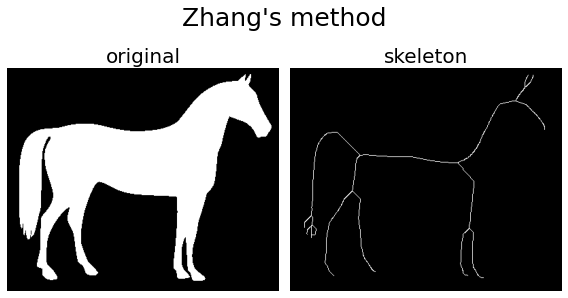

In [18]:
# Load image from skimage dataset
# Invert the horse image
image = np.array(invert(data.horse()))
print(image.shape)

# Skeletonize the image using Zhang's Method
skeleton = zhang_skeletonize(image, save_steps=False)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
fig.suptitle("Zhang's method", fontsize=25)


In [ ]:
# Create video from images
!ffmpeg -y -framerate 25 -pattern_type glob -i 'stepbystep_exec/zhang/*.png' -c:v libx264 -pix_fmt yuv420p 'stepbystep_exec/zhang/zhang.mp4'

# Morphological Thinning

Morphological thinning is a morphological operation that removes pixels from a region of a binary image. As I said before it is commonly used as a skeletonization technique.

To do its magic morphological thinning relies on the Hit-or-Miss transform which one of the basic morphological operations.

### Hit-or-Miss Transform

The hit-or-miss transform is a general binary morphological operation that can be used to look for specific patterns of _foreground_ and _background_ pixels (respectively 1s and 0s pixels) an image.

It takes a binary image and a _structuring element_ or _kernel_ as input and outputs another binary image. The kernel can contain both 1s and 0s and some special `null` pixels which are not considered in the computation. For example in the following figure it is represented a 3x3 hit-or-miss kernel.

![isolate-point-kernel](https://drive.google.com/uc?id=1aHXhQh_BJ9ngTow08PK8RXTTKt6mVow6)

The hit-or-miss operation is performed simply iterating over all pixels of the image and comparing the _kernel_ with the underlying image pixels. If they exactly match the pixel under the pixel is set to 1 otherwise is set to 0.

### Thinning using the Hit-or-Miss Transform

The thinning operation is fairly simple. Given an image $I$ and a kernel $J$ is:

$ thin(I, J) = I-hit$-$and$-$miss(I,J)$

where the subtraction is the logical subtraction $X-Y = X \cap \neg Y$

In english, the pixel we're iterating on is set to 0 if the kernel and the underlying image pixels ("the neighborhood") _do not_ exactly match otherwise, it is left unchanged.

In order to obtain a skeleton the complete pass over the pixels of the image should be repeated until it causes no further changes.

### Skeletonization kernels

Skeletonization should erode away the boundaries of the object region as much as possible preserving the topological characteristics of the object, i.e. connectivity, holes, geometry etc.

This can be achieved using the two kernels shown below and all their 90° rotations. The first allows to detect a pixel belonging to a Nord, South, East or West border which can be deleted. The second allows to detect a pixel belonging to a Nord-East, South-East, Nord-West or South-West corner which can be deleted.

This can be achieved using the two kernels shown below and all their 90° rotations. In this way we're determining the _octagonal skeleton_ of the region, i.e. the set of point that lie at the centers of octagons that fit entirely inside the region without touching the boundary at at least two points.
This method is guaranteed to produce a connected skeleton.

![corner-kernel](https://drive.google.com/uc?id=1aKpZhFD11uUJcW4i3bKvWYazgB13oFkN)
![border-kernel](https://drive.google.com/uc?id=1aG2FNu6ID3N8PoGkXGMYYzIuc9jxpQYI)

Skeletons obtained by this tecnique can present short spurs produced by small irregularities in the boundary of the original object. In the image below it is possibile to see the spurs after obtaining the skeleton.

![spur-example](https://drive.google.com/uc?id=1aRpBKrHLvxQXYr2kcSe4BZqZlALjSKBU)

These spurs can be removed by a process called pruning. The kernels used to perform pruning are the following and all their 90° rotations. Pruning should be performed for a fixed number of iterations instead of to convergence since pruning until convergence will actually remove all pixels except those that form closed loops.

![spur-1-kernel](https://drive.google.com/uc?id=1aPYgHMVB4Li7wBXwUA4c761oG2BHoaf9)
![spur-2-kernel](https://drive.google.com/uc?id=1aR4UJLXKcqgU0ojC6LYUvbGnc5nw-pDI)


In [15]:
# 0 pixels are the "null" pixels, -1 pixels are background pixels, 1 pixels are foreground pixels
border_kernel = np.array([[0, -1, -1], [1, 1, -1], [0, 1, 0]], dtype="int")
corner_kernel = np.array([[-1, -1, -1], [0, 1, 0], [1, 1, 1]], dtype="int")

kernels = [
    border_kernel,
    corner_kernel,
    np.rot90(border_kernel),
    np.rot90(corner_kernel),
    np.rot90(np.rot90(border_kernel)),
    np.rot90(np.rot90(corner_kernel)),
    np.rot90(np.rot90(np.rot90(border_kernel))),
    np.rot90(np.rot90(np.rot90(corner_kernel)))
]

spur1_kernel = np.array([[-1, -1, -1], [-1, 1, -1], [0, 0, -1]], dtype="int")
spur2_kernel = np.array([[-1, -1, -1], [-1, 1, -1], [-1, 0, 0]], dtype="int")

spur_kernels = [
    spur1_kernel,
    spur2_kernel,
    np.rot90(spur1_kernel),
    np.rot90(spur2_kernel),
    np.rot90(np.rot90(spur1_kernel)),
    np.rot90(np.rot90(spur2_kernel)),
    np.rot90(np.rot90(np.rot90(spur1_kernel))),
    np.rot90(np.rot90(np.rot90(spur2_kernel))),
]


def write_frames(path, image, index, show=False):
    image_to_print = image.astype(np.uint8)  # convert to an unsigned byte
    image_to_print *= 255
    cv2.imwrite(f"{path}img_{index:03}.png", image_to_print)
    if show:
        cv2.imshow("Frame", image_to_print)
        cv2.waitKey(0)


def morph_thinning_skeletonize(image, save_steps=False, path_to_save_steps="stepbystep_exec/morph_thinning/", pruning=False, pruning_iters=10):
    '''Given a 2D binary image, skeletonize it using Zhang's Method'''

    # add padding of zeros to avoid to access out of bounds
    cleaned_skeleton = np.pad(
        image, pad_width=1, mode='constant', constant_values=0)
    cleaned_skeleton = cleaned_skeleton.astype(np.uint8)
    rows, cols = cleaned_skeleton.shape
    skeleton = np.zeros(cleaned_skeleton.shape, dtype=np.uint8)
    skeleton[:, :] = cleaned_skeleton > 0
    pixel_removed = True
    step = 0
    while pixel_removed:
        pixel_removed = False

        cleaned_skeleton = thin(cleaned_skeleton, kernels)

        diff = np.zeros(skeleton.shape, dtype=np.uint8)
        cv2.absdiff(cleaned_skeleton, skeleton, diff)
        if cv2.countNonZero(diff) > 0:
            skeleton = cleaned_skeleton
            pixel_removed = True

        if save_steps:
            if step % 1 == 0:
                write_frames(path_to_save_steps, skeleton, step)
        step += 1
        #print(f"Step {step}")

    if pruning:
        pixel_removed = True
        for i in range(pruning_iters):
            if not pixel_removed:
                break

            cleaned_skeleton = thin(cleaned_skeleton, spur_kernels)

            diff = np.zeros(skeleton.shape, dtype=np.uint8)
            cv2.absdiff(skeleton, cleaned_skeleton, diff)
            if cv2.countNonZero(diff) > 0:
                skeleton = cleaned_skeleton
                pixel_removed = True

            if save_steps:
                write_frames(path_to_save_steps, skeleton, step+i)
                #print(f"Pruning step {i}")

    return skeleton[1:-1, 1:-1]


def thin(image, kernels):
    for kernel in kernels:
        out_image = cv2.morphologyEx(image, cv2.MORPH_HITMISS, kernel)
        image = image - out_image
    return image


(328, 400)


Text(0.5, 0.98, 'Morphological Thinning')

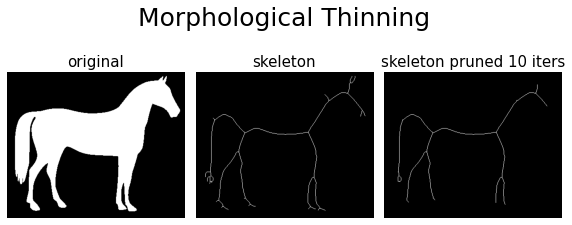

In [29]:
# Load image from skimage dataset
# Invert the horse image
image = np.array(invert(data.horse()))
print(image.shape)

skeleton_pruned = morph_thinning_skeletonize(
    image, save_steps=True, path_to_save_steps="stepbystep_exec/morph_thinning/", pruning=True)
skeleton = morph_thinning_skeletonize(
    image, save_steps=True, path_to_save_steps="stepbystep_exec/morph_thinning/")

# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=15)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=15)

ax[2].imshow(skeleton_pruned, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('skeleton pruned 10 iters', fontsize=15)

fig.tight_layout()
fig.suptitle("Morphological Thinning", fontsize=25)


In [ ]:
!ffmpeg -y -framerate 25 -pattern_type glob -i 'stepbystep_exec/morph_thinning/*.png' -c:v libx264 -pix_fmt yuv420p 'stepbystep_exec/morph_thinning/morph_thinning.mp4'

# Lee's 3d Skeletonization 
For a detailed explanation on how the algorithm works it is necessary to read the original article. 

Anyway, each function of the code below is documented with a brief explanation with references to the article.

[Lee94] T.-C. Lee, R.L. Kashyap and C.-N. Chu, Building skeleton models
       via 3-D medial surface/axis thinning algorithms.
       Computer Vision, Graphics, and Image Processing, 56(6):462-478, 1994.

The code below is a traslation in Python from the Cython implementation of `scikit-image` library.

In [16]:
"""
References
----------
.. [Lee94] T.-C. Lee, R.L. Kashyap and C.-N. Chu, Building skeleton models
       via 3-D medial surface/axis thinning algorithms.
       Computer Vision, Graphics, and Image Processing, 56(6):462-478, 1994.

.. [IAC15] Ignacio Arganda-Carreras, 2015. Skeletonize3D plugin for ImageJ(C).
           https://imagej.net/Skeletonize3D

"""
from dataclasses import dataclass


@dataclass
class coordinate:
    p: int
    r: int
    c: int


def compute_thin_image(img):
    """Compute a thin image.

    Loop through the image multiple times, removing "simple" points, i.e.
    those point which can be removed without changing local connectivity in the
    3x3x3 neighborhood of a point.

    This routine implements the two-pass algorithm of [Lee94]_. Namely,
    for each of the six border types (positive and negative x-, y- and z-),
    the algorithm first collects all possibly deletable points, and then
    performs a sequential rechecking.

    The input, `img`, is assumed to be a 3D binary image in the
    (p, r, c) format [i.e., C ordered array], filled by zeros (background) and
    ones. Furthermore, `img` is assumed to be padded by zeros from all
    directions --- this way the zero boundary conditions are automatic
    and there is need to guard against out-of-bounds access.

    """
    unchanged_borders = 0
    num_borders = 6
    borders = [4, 3, 2, 1, 5, 6]
    simple_border_points = []
    neighb = [0]*27

    # no need to worry about the z direction if the original image is 2D
    if img.shape[0] == 3:
        num_borders = 4

    # loop through the image several times until there is no change for all
    # the six border types
    while unchanged_borders < num_borders:
        unchanged_borders = 0
        for j in range(num_borders):
            curr_border = borders[j]

            find_simple_point_candidates(
                img, curr_border, simple_border_points)

            # sequential re-checking to preserve connectivity when deleting in a parallel way. See section 3.0 in [Lee94]
            no_change = True
            num_border_points = len(simple_border_points)
            for i in range(num_border_points):
                point = simple_border_points[i]
                p = point.p
                r = point.r
                c = point.c
                get_neighborhood(img, p, r, c, neighb)

                if is_simple_point(neighb):
                    img[p, r, c] = 0
                    no_change = False
            if no_change:
                unchanged_borders += 1

    return img


def find_simple_point_candidates(img, curr_border, simple_border_points):
    """Inner loop of compute_thin_image.

    The algorithm of [Lee94]_ proceeds in two steps: (1) six directions are
    checked for simple border points to remove, and (2) these candidates are
    sequentially rechecked, see Sec 3 of [Lee94]_ for rationale and discussion.

    This routine implements the first step above: it loops over the image
    for a given direction and assembles candidates for removal.
    """
    neighborhood = [0]*27
    is_border_pt = False
    Euler_LUT = LUT

    # clear the output vector
    simple_border_points.clear()

    # loop through the image
    # NB: each loop is from 1 to size-1: img is padded from all sides
    for p in range(1, img.shape[0] - 1):
        for r in range(1, img.shape[1] - 1):
            for c in range(1, img.shape[2] - 1):
                # check if pixel is foreground
                if img[p, r, c] != 1:
                    continue
                is_border_pt = (curr_border == 1 and img[p, r, c-1] == 0 or  # N
                                # S
                                curr_border == 2 and img[p, r, c+1] == 0 or
                                # E
                                curr_border == 3 and img[p, r+1, c] == 0 or
                                # W
                                curr_border == 4 and img[p, r-1, c] == 0 or
                                # U
                                curr_border == 5 and img[p+1, r, c] == 0 or
                                curr_border == 6 and img[p-1, r, c] == 0)  # B
                if not is_border_pt:
                    # current point is not deletable
                    continue

                get_neighborhood(img, p, r, c, neighborhood)

                # check if (p, r, c) can be deleted:
                # * it must not be an endpoint;
                # * it must be Euler invariant (condition 1 in [Lee94]_); and
                # * it must be simple (i.e., its deletion does not change
                #   connectivity in the 3x3x3 neighborhood)
                #   this is conditions 2 and 3 in [Lee94]_
                if (is_endpoint(neighborhood) or
                    not is_Euler_invariant(neighborhood, Euler_LUT) or
                        not is_simple_point(neighborhood)):
                    continue

                # ok, add (p, r, c) to the list of simple border points
                point = coordinate(p, r, c)
                simple_border_points.append(point)


def get_neighborhood(img, p, r,  c, neighborhood):
    """Get the neighborhood of a pixel.

    Assume zero boundary conditions.
    Image is already padded, so no out-of-bounds checking.

    For the numbering of points see Fig. 1a. of [Lee94]_, where the numbers
    do *not* include the center point itself. OTOH, this numbering below
    includes it as number 13. The latter is consistent with [IAC15]_.
    """
    neighborhood[0] = img[p-1, r-1, c-1]
    neighborhood[1] = img[p-1, r,   c-1]
    neighborhood[2] = img[p-1, r+1, c-1]

    neighborhood[3] = img[p-1, r-1, c]
    neighborhood[4] = img[p-1, r,   c]
    neighborhood[5] = img[p-1, r+1, c]

    neighborhood[6] = img[p-1, r-1, c+1]
    neighborhood[7] = img[p-1, r,   c+1]
    neighborhood[8] = img[p-1, r+1, c+1]

    neighborhood[9] = img[p, r-1, c-1]
    neighborhood[10] = img[p, r,   c-1]
    neighborhood[11] = img[p, r+1, c-1]

    neighborhood[12] = img[p, r-1, c]
    neighborhood[13] = img[p, r,   c]
    neighborhood[14] = img[p, r+1, c]

    neighborhood[15] = img[p, r-1, c+1]
    neighborhood[16] = img[p, r,   c+1]
    neighborhood[17] = img[p, r+1, c+1]

    neighborhood[18] = img[p+1, r-1, c-1]
    neighborhood[19] = img[p+1, r,   c-1]
    neighborhood[20] = img[p+1, r+1, c-1]

    neighborhood[21] = img[p+1, r-1, c]
    neighborhood[22] = img[p+1, r,   c]
    neighborhood[23] = img[p+1, r+1, c]

    neighborhood[24] = img[p+1, r-1, c+1]
    neighborhood[25] = img[p+1, r,   c+1]
    neighborhood[26] = img[p+1, r+1, c+1]


def fill_Euler_LUT():
    """ Look-up table for preserving Euler characteristic.

    This is column $\delta G_{26}$ of Table 2 of [Lee94]_.
    """

    arr = [1, -1, -1, 1, -3, -1, -1, 1, -1, 1, 1, -1, 3, 1, 1, -1, -3, -1,
           3, 1, 1, -1, 3, 1, -1, 1, 1, -1, 3, 1, 1, -1, -3, 3, -1, 1, 1,
           3, -1, 1, -1, 1, 1, -1, 3, 1, 1, -1, 1, 3, 3, 1, 5, 3, 3, 1,
           -1, 1, 1, -1, 3, 1, 1, -1, -7, -1, -1, 1, -3, -1, -1, 1, -1,
           1, 1, -1, 3, 1, 1, -1, -3, -1, 3, 1, 1, -1, 3, 1, -1, 1, 1,
           -1, 3, 1, 1, -1, -3, 3, -1, 1, 1, 3, -1, 1, -1, 1, 1, -1, 3,
           1, 1, -1, 1, 3, 3, 1, 5, 3, 3, 1, -1, 1, 1, -1, 3, 1, 1, -1]

    LUT = np.zeros(256, dtype=np.intc)
    LUT[1::2] = arr
    return LUT


LUT = fill_Euler_LUT()

# Fill the look-up table for indexing octants for computing the Euler
# characteristic. See is_Euler_invariant routine below.
neighb_idx = [[2, 1, 11, 10, 5, 4, 14],      # NEB
              [0, 9, 3, 12, 1, 10, 4],       # NWB
              [8, 7, 17, 16, 5, 4, 14],      # SEB
              [6, 15, 7, 16, 3, 12, 4],      # SWB
              [20, 23, 19, 22, 11, 14, 10],  # NEU
              [18, 21, 9, 12, 19, 22, 10],   # NWU
              [26, 23, 17, 14, 25, 22, 16],  # SEU
              [24, 25, 15, 16, 21, 22, 12],  # SWU
              ]


def is_Euler_invariant(neighbors, lut):
    """Check if a point is Euler invariant.

    Calculate Euler characteristic for each octant and sum up.

    Parameters
    ----------
    neighbors
        neighbors of a point
    lut
        The look-up table for preserving the Euler characteristic.

    Returns
    -------
    bool (whether it is or not)
    """
    euler_char = 0
    for octant in range(8):
        n = 1
        for j in range(7):
            idx = neighb_idx[octant][j]
            if neighbors[idx] == 1:
                n |= 1 << (7 - j)  # maybe doesn't work!!!

        euler_char += lut[n]
    return euler_char == 0


def is_endpoint(neighbors):
    """An endpoint has exactly one neighbor in the 26-neighborhood.
    """
    # The center pixel is counted, thus r.h.s. is 2
    s = 0
    for j in range(27):
        s += neighbors[j]
    return s == 2


def is_simple_point(neighbors):
    """Check is a point is a Simple Point.

    A point is simple iff its deletion does not change connectivity in
    the 3x3x3 neighborhood. (cf conditions 2 and 3 in [Lee94]_).

    This method is named "N(v)_labeling" in [Lee94]_.

    Parameters
    ----------
    neighbors : array, shape(27,)
        neighbors of the point

    Returns
    -------
    bool
        Whether the point is simple or not.
    """
    cube = neighbors[:13] + neighbors[14:]
    label = 2
    for i in range(26):
        if cube[i] == 1:
            # voxel has not been labeled yet
            # start recursion with any octant that contains the point i
            if i in (0, 1, 3, 4, 9, 10, 12):
                octree_labeling(1, label, cube)
            elif i in (2, 5, 11, 13):
                octree_labeling(2, label, cube)
            elif i in (6, 7, 14, 15):
                octree_labeling(3, label, cube)
            elif i in (8, 16):
                octree_labeling(4, label, cube)
            elif i in (17, 18, 20, 21):
                octree_labeling(5, label, cube)
            elif i in (19, 22):
                octree_labeling(6, label, cube)
            elif i in (23, 24):
                octree_labeling(7, label, cube)
            elif i == 25:
                octree_labeling(8, label, cube)
            label += 1
            if label - 2 >= 2:
                return False
    return True


octree = [
    # octant 1
    ([0, 1, 3, 4, 9, 10, 12],
     [[], [2], [3], [2, 3, 4], [5], [2, 5, 6], [3, 5, 7]]),
    # octant 2
    ([1, 4, 10, 2, 5, 11, 13],
     [[1], [1, 3, 4], [1, 5, 6], [], [4], [6], [4, 6, 8]]),
    # octant 3
    ([3, 4, 12, 6, 7, 14, 15],
     [[1], [1, 2, 4], [1, 5, 7], [], [4], [7], [4, 7, 8]]),
    # octant 4
    ([4, 5, 13, 7, 15, 8, 16],
     [[1, 2, 3], [2], [2, 6, 8], [3], [3, 7, 8], [], [8]]),
    # octant 5
    ([9, 10, 12, 17, 18, 20, 21],
     [[1], [1, 2, 6], [1, 3, 7], [], [6], [7], [6, 7, 8]]),
    # octant 6
    ([10, 11, 13, 18, 21, 19, 22],
     [[1, 2, 5], [2], [2, 4, 8], [5], [5, 7, 8], [], [8]]),
    # octant 7
    ([12, 14, 15, 20, 21, 23, 24],
     [[1, 3, 5], [3], [3, 4, 8], [5], [5, 6, 8], [], [8]]),
    # octant 8
    ([13, 15, 16, 21, 22, 24, 25],
     [[2, 4, 6], [3, 4, 7], [4], [5, 6, 7], [6], [7], []])
]


def octree_labeling(octant, label, cube):
    """This is a recursive method that calculates the number of connected
    components in the 3D neighborhood after the center pixel would
    have been removed.

    See Figs. 6 and 7 of [Lee94]_ for the values of indices.

    Parameters
    ----------
    octant : int
        octant index
    label : int
        the current label of the center point
    cube : array, shape(26,)
        local neighborhood of the point
    """
    # This routine checks if there are points in the octant with value 1
    # Then sets points in this octant to current label
    # and recursive labeling of adjacent octants.
    for oct in range(1, 9):
        if octant == oct:
            indices, list_octants = octree[oct-1]
            for idx, new_octants in zip(indices, list_octants):
                if cube[idx] == 1:
                    cube[idx] = label
                    for new_octant in new_octants:
                        octree_labeling(new_octant, label, cube)


In [17]:
def lee_skeletonize(img):
    """
    Performs skeletonization of binary image img using Lee's method for 3D Skeletonization.
    Works with 2D and 3D images.
    """
    img_3d = img
    # if image is 2D add a dimension 
    if img.ndim == 2:
        img_3d = img[np.newaxis, ...]
    # pad the image with a border of zeros all around
    img_3d = np.pad(img_3d, pad_width=1, mode='constant')

    skeleton = compute_thin_image(img_3d)
    if img.ndim ==2:
        return skeleton[1, 1:-1, 1:-1]
    return skeleton[1:-1, 1:-1, 1:-1]

(328, 400)


Text(0.5, 0.98, "Lee's method")

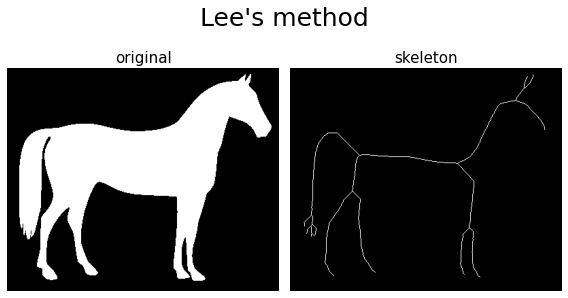

In [32]:
# Load image from skimage dataset
# Invert the horse image
image = np.array(invert(data.horse()))

# small_blob data
# image = np.array([
#     [0,0,0,0,0,0,0,0,0,0],
#     [0,0,0,0,1,0,0,0,0,0],
#     [0,0,1,1,1,1,1,1,0,0],
#     [0,1,1,1,1,1,1,0,0,0],
#     [0,0,1,1,0,0,0,0,0,0],
#     [0,0,1,1,1,0,1,1,0,0],
#     [0,0,1,1,1,1,1,1,1,0],
#     [0,0,0,1,0,0,0,0,0,0],
#     [0,0,0,1,0,0,0,0,0,0],
#     [0,0,0,0,0,0,0,0,0,0]
# ])

print(image.shape)

skeleton = lee_skeletonize(image)
# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=15)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=15)

fig.tight_layout()
fig.suptitle("Lee's method", fontsize=25)


# Play with the three methods

The code below allows to skeletonize any image loaded from the file system, using the three methods discussed and to visualize the results.

1. Load the image as RBG
2. Convert to grey scale 1 channel
3. Binarize the grey scale image using Otsu method
4. Skeletonize with the three different methods
5. Visualize results

Remember that skeletonization works on binary *regions* and if you have a rbg or a complex image colorwise (`astronaut.jpeg` for example), the binarization with Otsu method will not be enough to isolate the regions. You should apply some segmentation techniques before in order to obtain a well defined region to skeletonize.

Even with a simple k-means segmentation, the results on `astronaut.jpeg` are poor.

![astronaut](https://drive.google.com/uc?id=1aTlwGByThGpWrYItDYgKi0B2wxXW61ue)

Note: to run on our loved horse image it takes approx. 2 minutes

In [11]:
def segment_k_means(img, K=2, attempts=10):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    twoDimage = img.reshape((-1, 3))
    twoDimage = np.float32(twoDimage)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        twoDimage, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    result_image = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
    return result_image


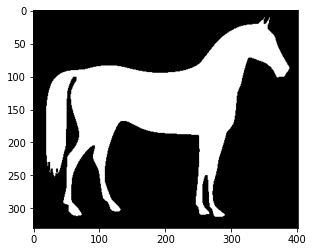

In [40]:
# segmentation use example
image = cv2.imread("sample_images/horse.png",
                   cv2.IMREAD_COLOR)  # choose your image

image_segmented = segment_k_means(image, K=2)
plt.imshow(image_segmented)

In [41]:
image = cv2.imread("sample_images/horse.png",
                   cv2.IMREAD_COLOR)  # choose your image

image = segment_k_means(image, K=2)

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, image_binary = cv2.threshold(
    image_gray, 128, 1, cv2.THRESH_OTSU)

skeletons = {
    'color': cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    'grey': image_gray,
    'binary': image_binary,
    'zhang-suen': zhang_skeletonize(image_binary),
    'morph-thin': morph_thinning_skeletonize(image_binary),
    'morph-thin-pruning': morph_thinning_skeletonize(image_binary, pruning=True),
    'lee': lee_skeletonize(image_binary),
}

titles = {'color': "Color",
          'grey': "Grey",
          'binary': "Binary",
          'zhang-suen': "Zhang-Suen's method",
          'morph-thin': "Morphological thinning",
          'morph-thin-pruning': "Morphological thinning with pruning",
          'lee': "Lee's method"}


Text(0.5, 0.98, 'Skeleton comparison')

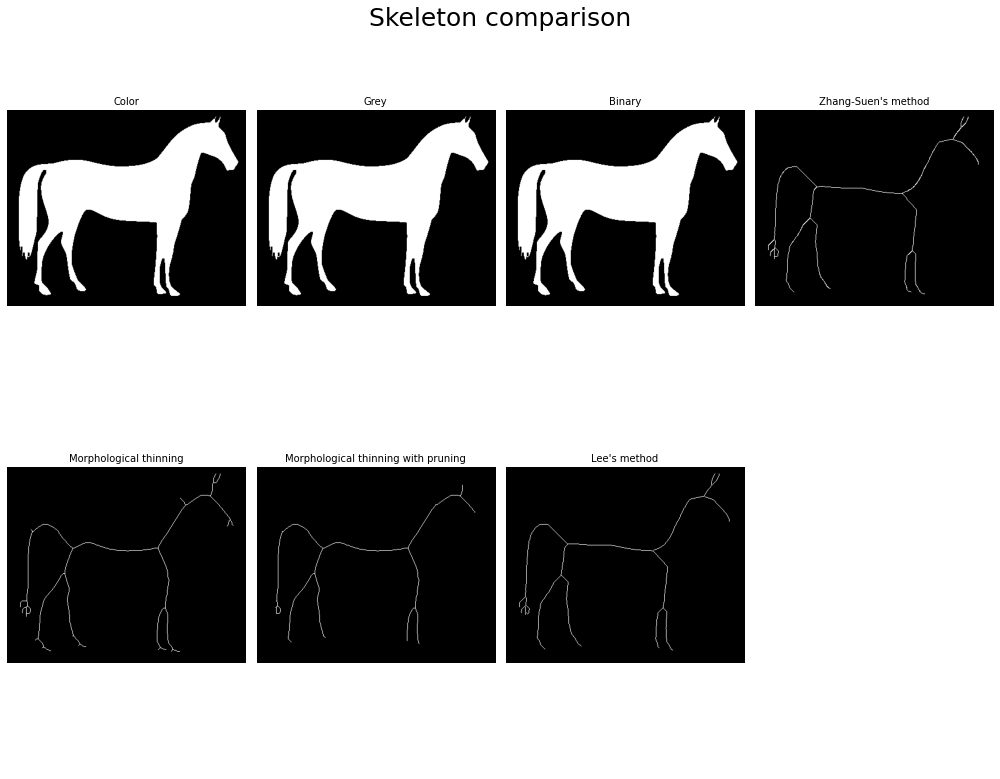

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 11),
                         sharex=True, sharey=True)

ax = axes.ravel()

for index, (a, key) in enumerate(zip(ax, skeletons.keys())):
    a.imshow(skeletons[key], cmap=plt.cm.gray)
    a.axis('off')
    a.set_title(titles[key], fontsize=10)

# avoid printing empty graph in below plot
for i in range(len(skeletons.keys())-1, len(ax)):
    ax[i].axis('off')

fig.tight_layout()
fig.suptitle("Skeleton comparison", fontsize=25)